Il file 'Data.csv' contiene i dati relativi al consumo di energia elettrica della macchina del caffè di Alexide.\
La colonna **Date** rappresenta data e ora della registrazione del sensore. Si noti che le date sono espresse in UTC.
Per convertirle nella timezone locale utilizzare\
`df['Date'] = pd.to_datetime(df['Date'], utc = True).dt.tz_convert('Europe/Berlin')`\
La colonna **Energy** rappresenta il consumo di energia totale, espresso in W*min (Watt minuto), a partire dall'accensione del sensore.
Si noti che il sensore è stato riavviato diverse volte nel periodo di osservazione e, a seguito di ciascun riavvio, il conteggio è ripartito da 0.\
La colonna **Topic** rappresenta il topic del messaggio mqtt ricevuto dal sensore.

Rappresentare i consumi totali in kWh (kiloWatt ora) con una heatmap che abbia sull'asse x le ore del giorno e sull'asse y il giorno della settimana.

# Coffe Machine Heatmap

#### Installo le librerie necessarie

In [482]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime
from sklearn.linear_model import LinearRegression

### 1.Importo il dataframe

In [483]:
df = pd.read_csv('data.csv',  sep=';')

In [484]:
df['Date'] = pd.to_datetime(df['Date'], utc = True).dt.tz_convert('Europe/Berlin')

In [485]:
df = df.sort_values(['Date'])

### 2. Esploro il dataframe

In [486]:
# Verifico che la data sia stata convertita nel tipo corretto (datetime64)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54794 entries, 54793 to 50732
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype                        
---  ------  --------------  -----                        
 0   Energy  54794 non-null  int64                        
 1   Date    54794 non-null  datetime64[ns, Europe/Berlin]
 2   Topic   54794 non-null  object                       
dtypes: datetime64[ns, Europe/Berlin](1), int64(1), object(1)
memory usage: 1.7+ MB


### Pulisco e preparo i dati per l'analisi

##### Divido la colonna Energy che contiene W*m per 1000, in modo da ottenere la stessa colonna, ma espressa in Kw/h

Text(0, 0.5, 'Energy')

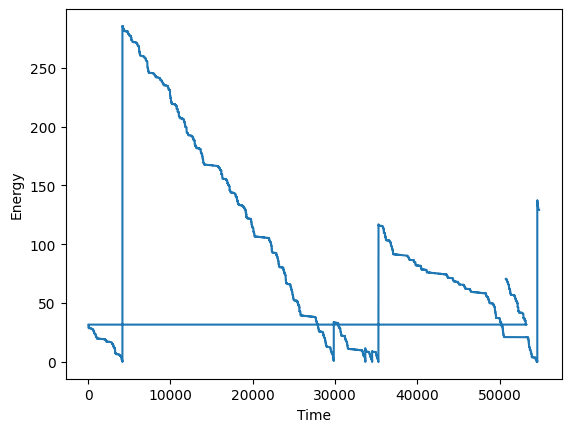

In [487]:
df['Energy'] = df['Energy'] / 1000 
plot = df['Energy'].plot()
plot.set_xlabel("Time")
plot.set_ylabel("Energy")

##### Per ottenere il consumo, faccio la differenza fra i valori t e t+1 e poi filtro per solo i valori positivi (il consumo di corrente è sempre positivo e crescente)

In [488]:
df['DeltaEnergy'] = df['Energy'].diff()

<AxesSubplot: >

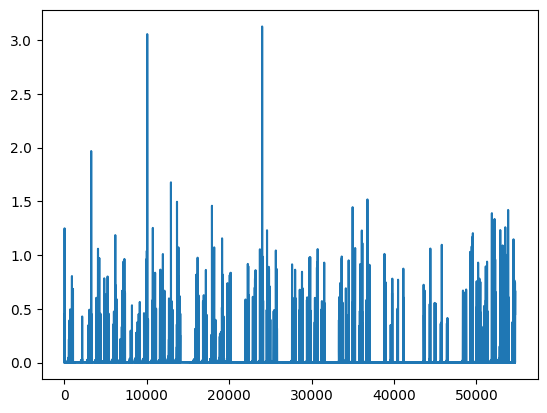

In [489]:
df = df[df['DeltaEnergy'] > 0]
df['DeltaEnergy'].plot()

In [490]:
df

,Energy,Date,Topic,DeltaEnergy
54689,129.652,2022-08-01 09:20:02+02:00,shellies/shellyplug-s-D9B9EB/relay/0/energy,0.452
54690,130.256,2022-08-01 09:21:25+02:00,shellies/shellyplug-s-D9B9EB/relay/0/energy,0.604
54691,130.924,2022-08-01 09:22:09+02:00,shellies/shellyplug-s-D9B9EB/relay/0/energy,0.668
54692,131.106,2022-08-01 09:23:06+02:00,shellies/shellyplug-s-D9B9EB/relay/0/energy,0.182
54685,131.107,2022-08-01 09:24:03+02:00,shellies/shellyplug-s-D9B9EB/relay/0/energy,0.001
...,...,...,...,...
50728,70.544,2022-10-06 18:39:00+02:00,shellies/shellyplug-s-D9B9EB/relay/0/energy,0.002
50729,70.546,2022-10-06 18:40:01+02:00,shellies/shellyplug-s-D9B9EB/relay/0/energy,0.002
50730,70.548,2022-10-06 18:41:24+02:00,shellies/shellyplug-s-D9B9EB/relay/0/energy,0.002
50731,70.559,2022-10-06 18:42:01+02:00,shellies/shellyplug-s-D9B9EB/relay/0/energy,0.011


#####  Raggruppo i dati per ogni ora e calcolo la somma dei valori della colonna 'DeltaEnergy' per ogni gruppo orario creato, poi ripristino gli indici del DataFrame

<AxesSubplot: >

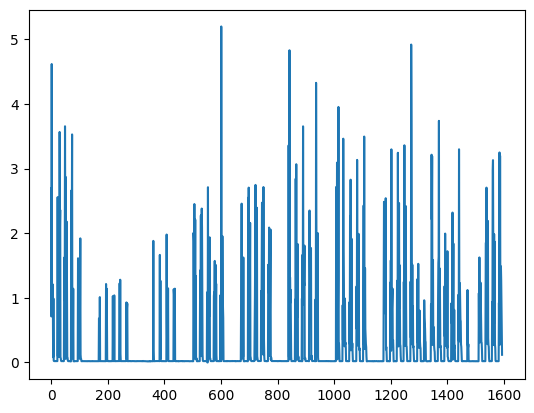

In [491]:
df = df.resample('1H', on='Date').agg({'DeltaEnergy': 'sum'}).reset_index()
df['DeltaEnergy'].plot()

##### Creo una copia del df che mi servirà in seguito per analizzare i picchi di consumo

In [492]:
peak= df
peak

,Date,DeltaEnergy
0,2022-08-01 09:00:00+02:00,2.689
1,2022-08-01 10:00:00+02:00,0.712
2,2022-08-01 11:00:00+02:00,4.617
3,2022-08-01 12:00:00+02:00,1.127
4,2022-08-01 13:00:00+02:00,0.854
...,...,...
1589,2022-10-06 14:00:00+02:00,1.488
1590,2022-10-06 15:00:00+02:00,1.264
1591,2022-10-06 16:00:00+02:00,0.847
1592,2022-10-06 17:00:00+02:00,0.298


### Costruisco l'heatmap

##### Ricavo l'ora  e il giorno della settimana dalla colonna Date, che essendo in formato Datetime64 offre strumenti built-in in Pandas

In [493]:
df["Hour"] = df["Date"].dt.hour
df["Weekday"] = df["Date"].dt.weekday
linear_df = df[['DeltaEnergy', 'Hour']]

##### Raggruppo i consumi in KwH in base al giorno e all'ora e ne faccio la media

In [494]:
df = df.groupby(['Weekday', 'Hour']).mean()
df

C:\Users\Gerry\AppData\Local\Temp\ipykernel_5352\3394141787.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby(['Weekday', 'Hour']).mean()


DeltaEnergy
Weekday Hour             
0       0        0.020778
        1        0.020444
        2        0.020111
        3        0.020444
        4        0.020222
...                   ...
6       19       0.019778
        20       0.020222
        21       0.020222
        22       0.020556
        23       0.020778

[168 rows x 1 columns]

##### Uso unstack e droplevel per ottenere tante colonne quante sono le ore

In [495]:
df = df.unstack()

In [496]:
df.columns = df.columns.droplevel(0)
df

Hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Weekday,,,,,,,,,,,,,,,,,,,,,
0,0.020778,0.020444,0.020111,0.020444,0.020222,0.020778,0.020444,0.117667,1.333222,1.258900,...,1.009500,0.740300,0.884100,0.254400,0.118500,0.076100,0.034900,0.020800,0.020600,0.021200
1,0.020700,0.021300,0.020700,0.021100,0.020800,0.020600,0.021200,0.412500,0.686400,1.496200,...,0.801700,1.071700,0.922700,0.385400,0.120100,0.055600,0.027700,0.020800,0.020800,0.021400
2,0.021200,0.020900,0.020700,0.020800,0.020400,0.021000,0.021200,0.657500,0.486400,1.317200,...,1.073600,0.626100,1.197700,0.640600,0.106700,0.066200,0.032800,0.021300,0.021000,0.021000
3,0.021200,0.021100,0.020900,0.020900,0.020800,0.020800,0.021400,0.431600,0.688900,1.588700,...,1.043600,1.105100,0.426500,0.214500,0.087500,0.069444,0.023667,0.021556,0.021444,0.021222
4,0.021222,0.021000,0.020778,0.020778,0.020778,0.021222,0.021000,0.376556,0.666556,1.561222,...,0.927222,0.828667,0.690444,0.192222,0.092111,0.047222,0.020444,0.021444,0.021111,0.021000
5,0.021222,0.021000,0.021000,0.021111,0.020556,0.020778,0.021000,0.161889,0.052778,0.053444,...,0.052667,0.107667,0.176778,0.073778,0.066556,0.049333,0.021000,0.020444,0.020667,0.020556
6,0.021000,0.021111,0.020556,0.020778,0.020667,0.021111,0.021000,0.125778,0.095444,0.084333,...,0.020556,0.020111,0.020333,0.020222,0.019667,0.019778,0.020222,0.020222,0.020556,0.020778


##### Uso l'heatmap di Seaborn per costruire l'heatmap per rappresentare graficamente i consumi per fasce orarie nei giorni della settimana

Text(50.722222222222214, 0.5, 'Giorni della settimana')

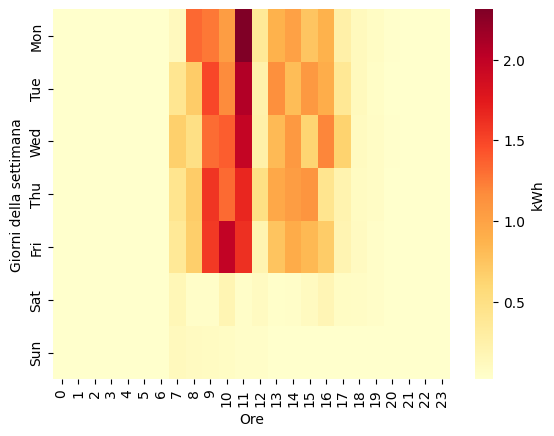

In [497]:
import seaborn as sns
ax = sns.heatmap(df, cmap="YlOrRd",yticklabels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], xticklabels=range(24))
cbar = ax.collections[0].colorbar
cbar.set_label("kWh")
ax.set_xlabel("Ore")
ax.set_ylabel("Giorni della settimana")

### Analisi dei picchi di consumo in relazione ai giorni

##### Utilizzo il Dataframe Peak creato in precedenza<br>Trovo il massimo e poi lo uso come riferimento per identificare i picchi

Il picco di consumo è stato raggiunto il 2022-08-26 10:00:00+02:00 con un valore di 5.198 kWh


Text(0, 0.5, 'Numero di picchi')

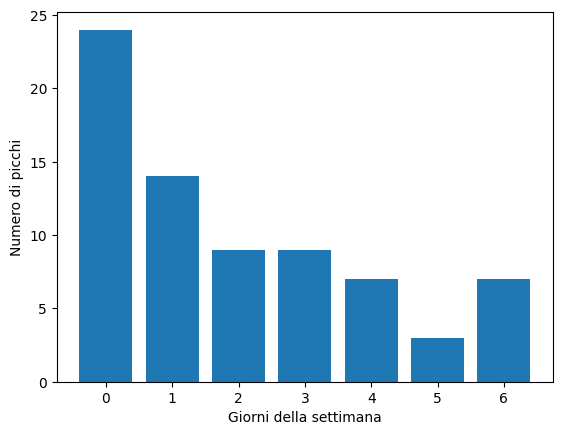

In [498]:
peak_index = peak['DeltaEnergy'].idxmax()
peak_value = peak.loc[peak_index, 'DeltaEnergy']
peak_date = peak.loc[peak_index, 'Date']
print("Il picco di consumo è stato raggiunto il {} con un valore di {} kWh".format(peak_date, peak_value))

peak['rolling_max'] = peak['DeltaEnergy'].rolling(window=24).max()

# Identify peaks by comparing current energy consumption to rolling max
peak['peak'] = peak['DeltaEnergy'] == peak['rolling_max']

# Analyze the data to understand when peaks occur
peak = peak[peak['peak'] == True]
plt.bar(peak.groupby(peak['Date'].dt.weekday).count().index, peak.groupby(peak['Date'].dt.weekday).count()['peak'])


plt.xlabel('Giorni della settimana')
plt.ylabel('Numero di picchi')

### Analisi della regressione lineare con Sklearn

##### In funzione dell'ora del giorno, provo a prevedere i consumi della macchinetta del caffè

In [499]:
linear_df

,DeltaEnergy,Hour
0,2.689,9
1,0.712,10
2,4.617,11
3,1.127,12
4,0.854,13
...,...,...
1589,1.488,14
1590,1.264,15
1591,0.847,16
1592,0.298,17


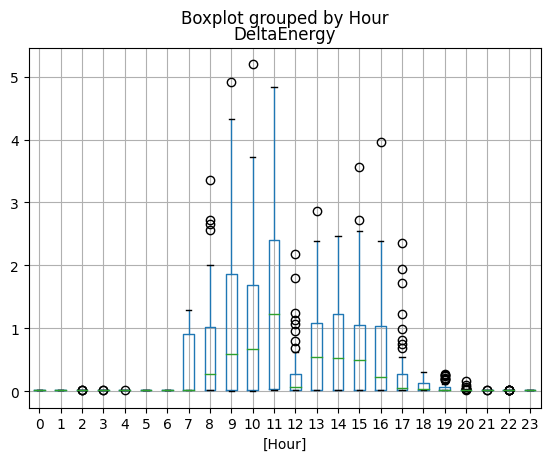

In [500]:
linear_df.boxplot(column=['DeltaEnergy',],by=['Hour']);

In [501]:
reg = LinearRegression()

In [502]:
x = linear_df['Hour']
y = linear_df['DeltaEnergy']

In [503]:
X = linear_df['Hour'].values.reshape(-1,1)

reg.fit(X, y)

LinearRegression()

In [504]:
m = reg.coef_[0]
q = reg.intercept_

print(m)
print(q)

0.0014404976618769309
0.32012260188638414


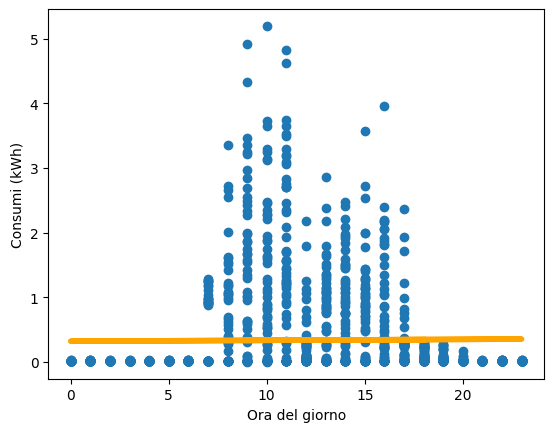

In [505]:
plt.scatter(x, y)
plt.plot(x, reg.predict(X), lw=4, c='orange', label ='regression line')
plt.xlabel('Ora del giorno')
plt.ylabel('Consumi (kWh)')
plt.show()

##### Train set and test set

In [506]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

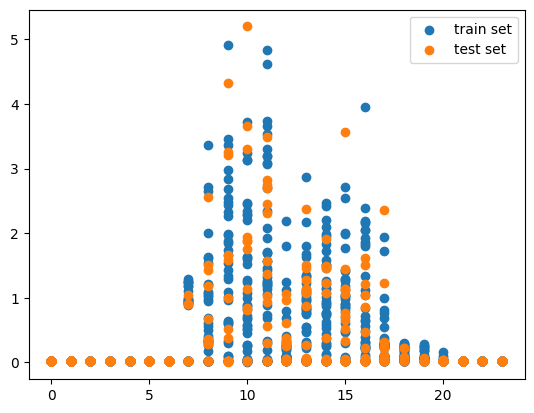

In [507]:
plt.scatter(X_train, y_train, label='train set')
plt.scatter(X_test, y_test, label='test set')
plt.legend()

In [508]:
reg = LinearRegression()

reg.fit(X_train, y_train)

LinearRegression()

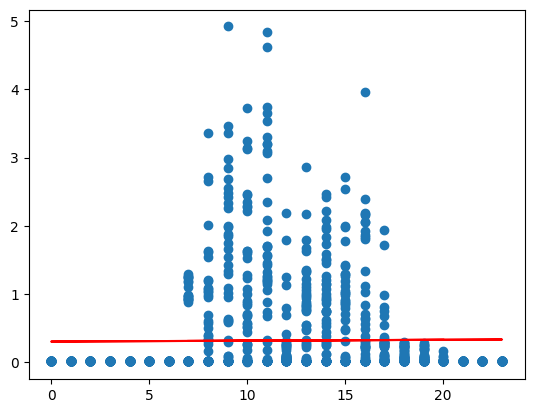

In [509]:
# prediction on train test
y_pred = reg.predict(X_train) 
plt.scatter(X_train, y_train)
plt.plot(X_train, y_pred, color='red')

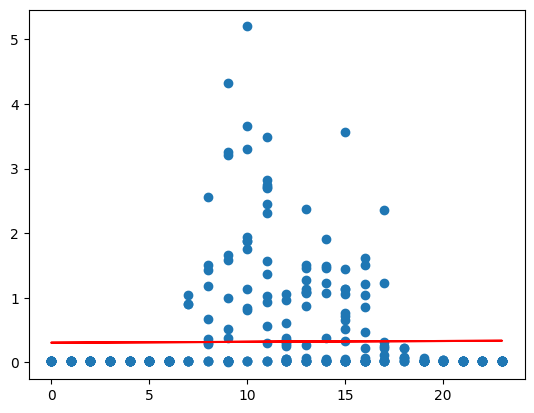

In [510]:
# prediction on test set
y_pred = reg.predict(X_test) 
plt.scatter(X_test, y_test)
plt.plot(X_test, y_pred, color='red')